In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
%matplotlib inline
sns.set()

In [2]:
df = pd.read_csv('framingham.csv') #reading the data

In [3]:
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


Demographic:
• Sex: male or female(Nominal)

• Age: Age of the patient;(Continuous - Although the recorded ages have been truncated to whole numbers, the concept of age is continuous)

Behavioral

• Current Smoker: whether or not the patient is a current smoker (Nominal)

• Cigs Per Day: the number of cigarettes that the person smoked on average in one day.(can be considered continuous as one can have any number of cigarettes, even half a cigarette.)

Medical( history)
• BP Meds: whether or not the patient was on blood pressure medication (Nominal)

• Prevalent Stroke: whether or not the patient had previously had a stroke (Nominal)

• Prevalent Hyp: whether or not the patient was hypertensive (Nominal)

• Diabetes: whether or not the patient had diabetes (Nominal)

Medical(current)

• Tot Chol: total cholesterol level (Continuous)

• Sys BP: systolic blood pressure (Continuous)

• Dia BP: diastolic blood pressure (Continuous)

• BMI: Body Mass Index (Continuous)

• Heart Rate: heart rate (Continuous - In medical research, variables such as heart rate though in fact discrete, yet are considered continuous because of large number of possible values.)

• Glucose: glucose level (Continuous)

Predict variable (desired target)

• 10 year risk of coronary heart disease CHD (binary: “1”, means “Yes”, “0” means “No”)


EDA + Data Pre-Processing

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
male               4238 non-null int64
age                4238 non-null int64
education          4133 non-null float64
currentSmoker      4238 non-null int64
cigsPerDay         4209 non-null float64
BPMeds             4185 non-null float64
prevalentStroke    4238 non-null int64
prevalentHyp       4238 non-null int64
diabetes           4238 non-null int64
totChol            4188 non-null float64
sysBP              4238 non-null float64
diaBP              4238 non-null float64
BMI                4219 non-null float64
heartRate          4237 non-null float64
glucose            3850 non-null float64
TenYearCHD         4238 non-null int64
dtypes: float64(9), int64(7)
memory usage: 529.9 KB


In [5]:
df.isna().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [6]:
df = df.interpolate(method='linear',axis=0)

In [7]:
# df['education'] = df['education'].fillna(df['education'].mean())
# df['cigsPerDay'] = df['cigsPerDay'].fillna(df['cigsPerDay'].mean())
# df['BPMeds'] = df['BPMeds'].fillna(df['BPMeds'].mean())
# df['totChol'] = df['totChol'].fillna(df['totChol'].mean())
# df['BMI'] = df['BMI'].fillna(df['BMI'].median())
# df['heartRate'] = df['heartRate'].fillna(df['heartRate'].mean())
# df['glucose'] = df['glucose'].fillna(df['glucose'].mean())

In [8]:
df.isna().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

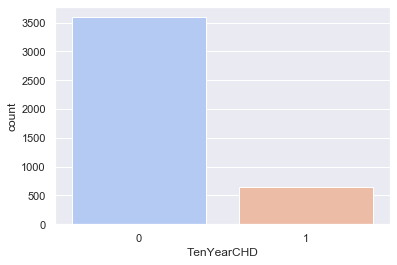

In [9]:
sns.countplot(x=df['TenYearCHD'],palette='coolwarm')

The Data is highly imbalanced. The model will tend to classify all of them as negative, which is something we do not want.

In [10]:
df['TenYearCHD'].value_counts()

0    3594
1     644
Name: TenYearCHD, dtype: int64

In [11]:
print('No', round(df['TenYearCHD'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Yes', round(df['TenYearCHD'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No 84.8 % of the dataset
Yes 15.2 % of the dataset


In [12]:
df = df.sample(frac=1)

yes_df = df.loc[df['TenYearCHD'] == 1]
no_df = df.loc[df['TenYearCHD'] == 0][:644]

df_balanced = pd.concat([yes_df, no_df])

df_balanced = df_balanced.sample(frac=1, random_state=42)

df_balanced.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
1339,1,52,1.0,1,15.0,0.0,0,0,0,240.0,120.0,77.0,32.27,80.0,62.0,0
2458,1,59,3.0,0,0.0,0.0,0,1,0,285.0,128.0,91.0,28.23,70.0,80.0,0
2690,0,63,1.0,0,0.0,0.0,0,0,0,246.0,116.0,69.0,23.44,65.0,78.0,1
97,0,40,2.0,0,0.0,0.0,0,0,0,205.0,100.0,60.0,25.18,60.0,72.0,1
878,1,51,1.0,1,20.0,0.0,0,1,0,239.0,168.0,102.0,30.38,82.0,68.0,1


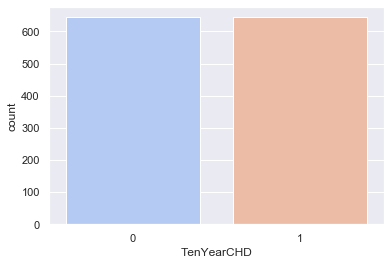

In [13]:
sns.countplot(x=df_balanced['TenYearCHD'],palette='coolwarm')

Here, we have brought the majority class(here, 0) to the same number of tuples as of the minority ratio to have a balanced datset in a 50-50 ratio

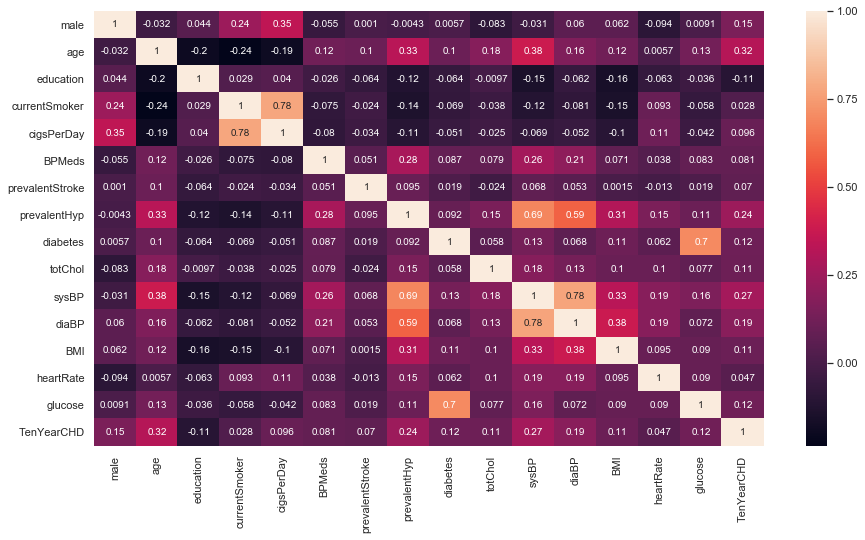

In [14]:
plt.figure(figsize=(15,8))
sns.heatmap(df_balanced.corr(),annot=True)

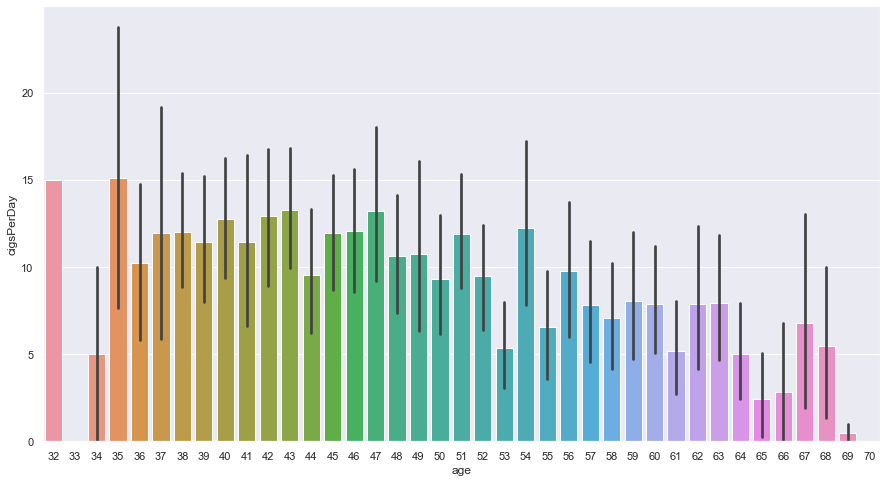

In [15]:
plt.figure(figsize=(15,8))
sns.barplot(x='age',y='cigsPerDay',data=df_balanced)

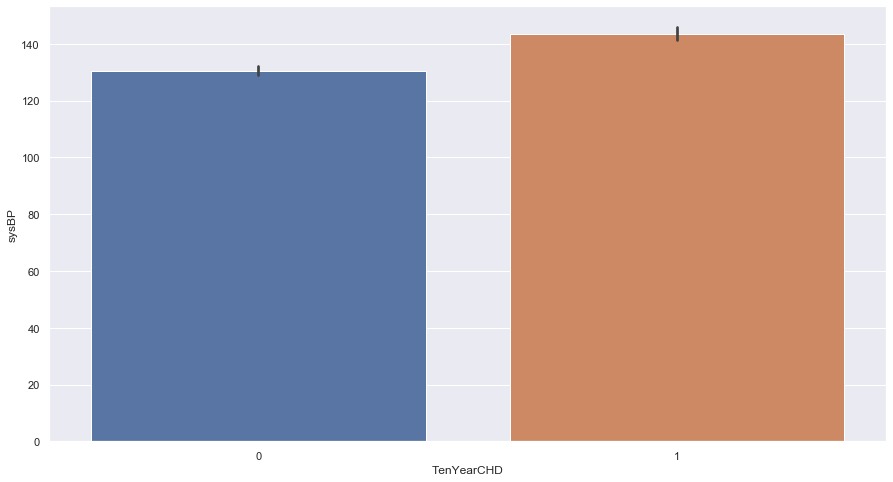

In [16]:
plt.figure(figsize=(15,8))
sns.barplot(x='TenYearCHD',y='sysBP',data=df_balanced)

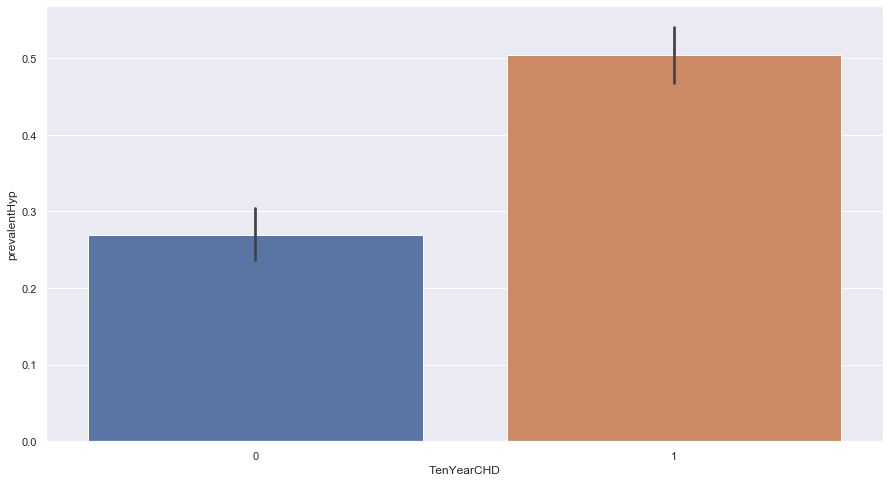

In [17]:
plt.figure(figsize=(15,8))
sns.barplot(x='TenYearCHD',y='prevalentHyp',data=df_balanced)

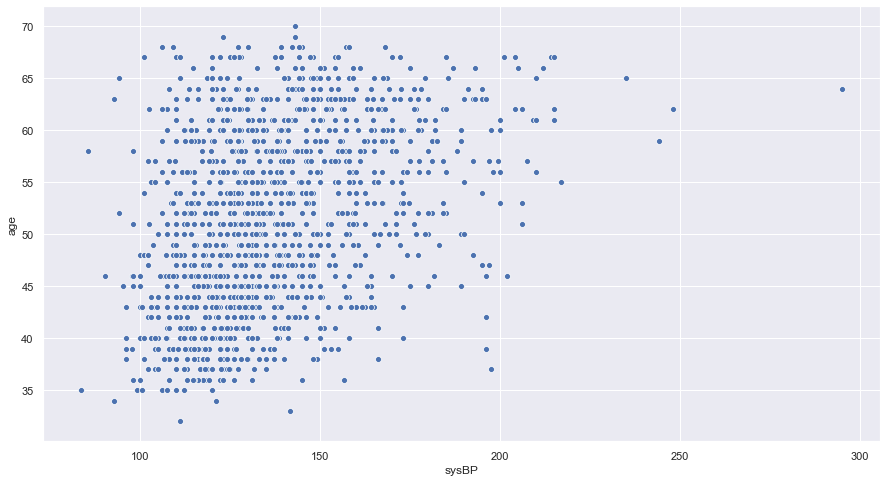

In [18]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='sysBP',y='age',data=df_balanced)

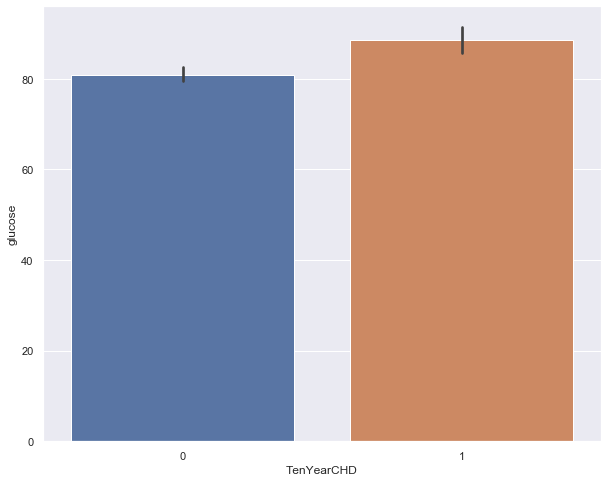

In [19]:
plt.figure(figsize=(10,8))
sns.barplot(x='TenYearCHD',y='glucose',data=df_balanced)

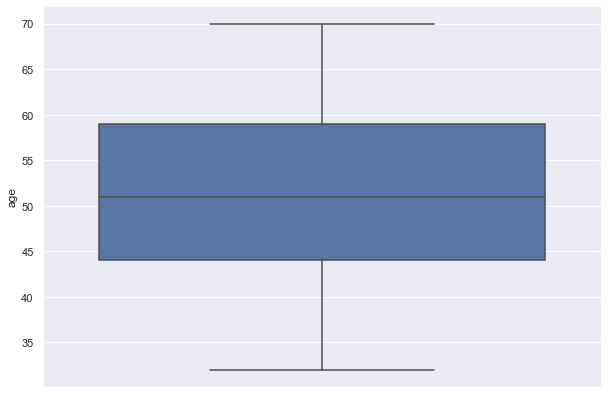

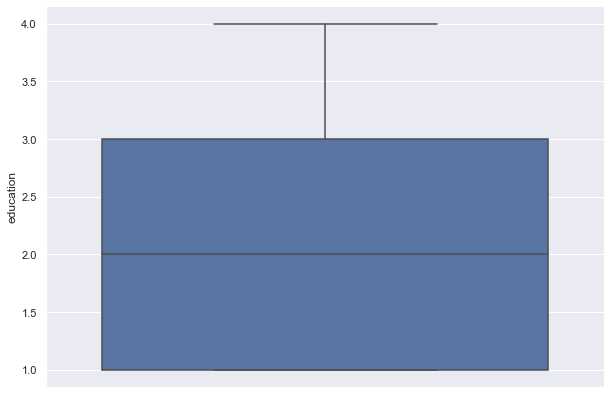

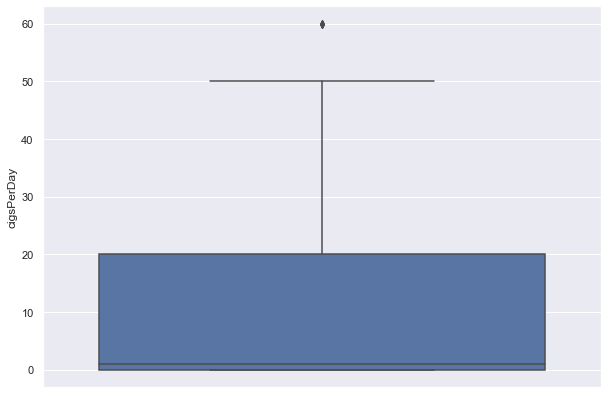

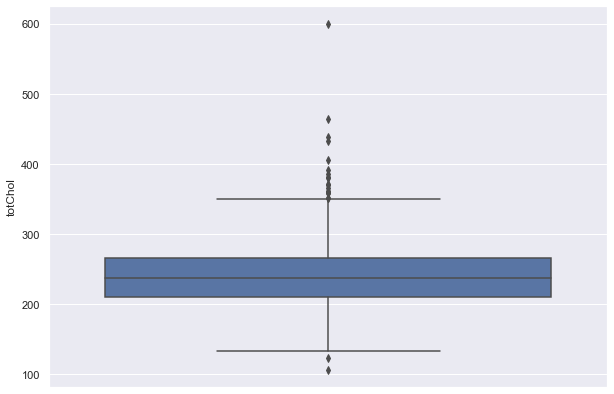

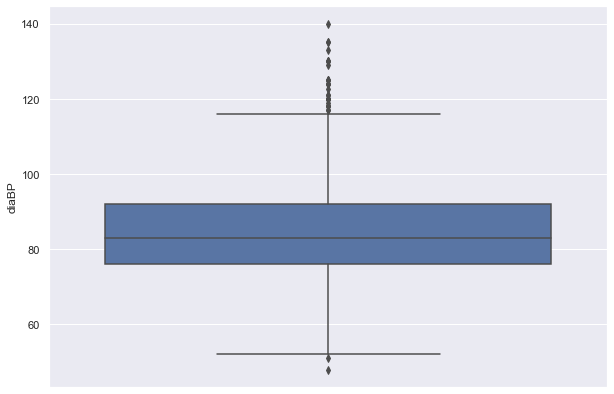

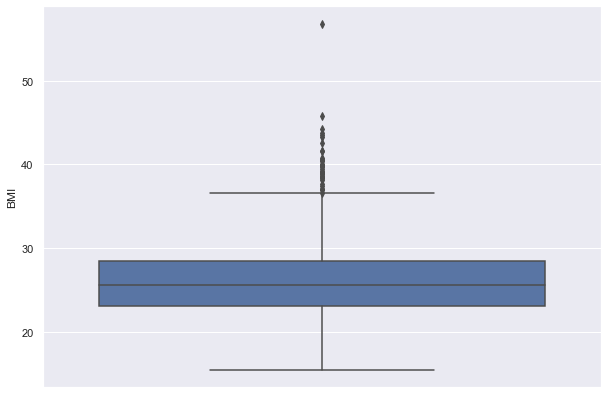

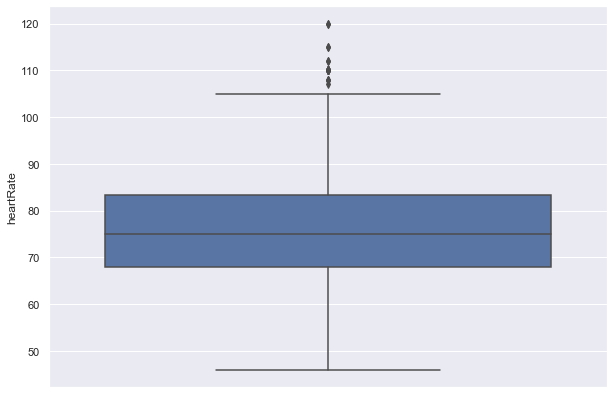

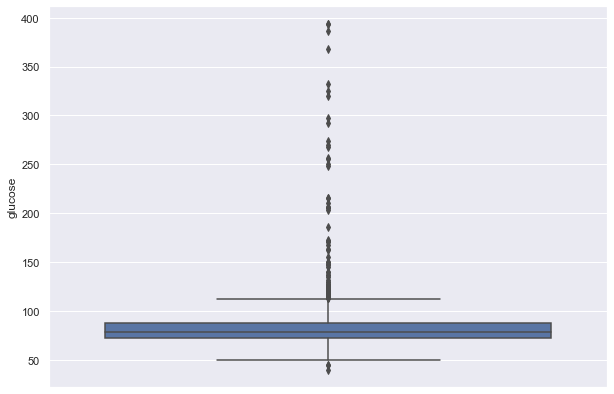

In [20]:
features = ['age','education','cigsPerDay','totChol','diaBP','BMI','heartRate','glucose']
for i in features:
    plt.figure(figsize=(10,7))
    sns.boxplot(y=df_balanced[i])

---------------------------------------------

In [21]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1288 entries, 1339 to 2121
Data columns (total 16 columns):
male               1288 non-null int64
age                1288 non-null int64
education          1288 non-null float64
currentSmoker      1288 non-null int64
cigsPerDay         1288 non-null float64
BPMeds             1288 non-null float64
prevalentStroke    1288 non-null int64
prevalentHyp       1288 non-null int64
diabetes           1288 non-null int64
totChol            1288 non-null float64
sysBP              1288 non-null float64
diaBP              1288 non-null float64
BMI                1288 non-null float64
heartRate          1288 non-null float64
glucose            1288 non-null float64
TenYearCHD         1288 non-null int64
dtypes: float64(9), int64(7)
memory usage: 211.1 KB


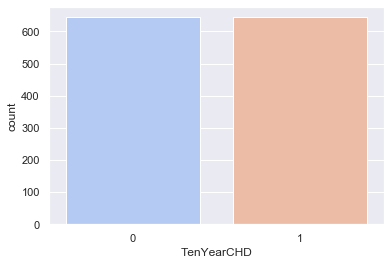

In [22]:
sns.countplot(x=df_balanced['TenYearCHD'],palette='coolwarm')

Logistic Regression on Original DataFrame and Under Sampled Data Frame

On Original DataFrame

In [23]:
X = df[['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose']]
y = df['TenYearCHD']

In [24]:
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [26]:
from sklearn.preprocessing import StandardScaler

In [27]:
sc= StandardScaler()

In [28]:
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [29]:
log_reg_params = {"penalty": ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],'tol':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

In [30]:
log_reg_pred =log_reg.predict(X_test)
print('\n')
print('Classification Report: \n ' ,(classification_report(y_test,log_reg_pred)))



Classification Report: 
                precision    recall  f1-score   support

           0       0.86      0.99      0.92      1077
           1       0.68      0.08      0.14       195

    accuracy                           0.85      1272
   macro avg       0.77      0.54      0.53      1272
weighted avg       0.83      0.85      0.80      1272



In [31]:
print(pd.crosstab(y_test.ravel(),log_reg_pred.ravel(),rownames=['Actual'],colnames=['Predicted'],margins=True))

Predicted     0   1   All
Actual                   
0          1070   7  1077
1           180  15   195
All        1250  22  1272


Although a good accuracy of around 85 % is achieved, if we have a look at the actual values, we notice that that 177/190 values are predicted as False(when they are infact True), which accounts for 90-93% of Actual values predicted as Not having a cardiac disease.

This is because there is a large imbalance between the number of cases for target class 0 and the target class 1.

The model has predicted the major class 0 for approximately all of the test data

-----------------

On Under-Sampled DataFrame

In [32]:
#ON A UNDERSAMPLED DATAFRAME DIRECTLY PRONE TO OVERFIT
X = df_balanced[['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose']]
y = df_balanced['TenYearCHD']

In [33]:
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [34]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [35]:
from sklearn.preprocessing import StandardScaler

In [36]:
sc= StandardScaler()

In [37]:
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [38]:
from sklearn.model_selection import GridSearchCV

In [39]:
log_reg_params = {"penalty": ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],'tol':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

In [40]:
log_reg_pred =log_reg.predict(X_test)
print('\n')
print('Classification Report: \n ' ,(classification_report(y_test,log_reg_pred)))



Classification Report: 
                precision    recall  f1-score   support

           0       0.71      0.62      0.66       169
           1       0.63      0.73      0.68       153

    accuracy                           0.67       322
   macro avg       0.67      0.67      0.67       322
weighted avg       0.68      0.67      0.67       322



In [41]:
print(pd.crosstab(y_test.ravel(),log_reg_pred.ravel(),rownames=['True'],colnames=['Predicted'],margins=True))

Predicted    0    1  All
True                    
0          105   64  169
1           42  111  153
All        147  175  322


Here, we notice that even though the accuracy has taken a hit, down to almost around 65-68%, the number of cases classified as negative(but are actually postive) is down to  1/3rd of the total number of positive samples.

Using SMOTE (Synthetic Minority Over-Sampling Technique)

SMOTE creates synthetic points from the minority class in order to reach an equal balance between the minority and majority class.

SMOTE picks the distance between the closest neighbors of the minority class, in between these distances it creates synthetic points.

More information is retained since we didn't have to delete any rows unlike in random undersampling.

In [42]:
sm = SMOTE(sampling_strategy='minority')

In [43]:
X = df[['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose']]
y = df['TenYearCHD']

In [44]:
from sklearn.model_selection import train_test_split

# This is explicitly used for oversampling.
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, test_size=0.25, random_state=42)

In [45]:
X_train_new, y_train_new = sm.fit_sample(X_train_new ,y_train_new.ravel())

In [46]:
X_train_new = X_train_new.values
X_test_new = X_test_new.values
y_test_new = y_test_new.values

In [47]:
y_test_new

array([1, 0, 0, ..., 1, 0, 0], dtype=int64)

In [48]:
X_train_new = sc.fit_transform(X_train_new)
X_test_new = sc.fit_transform(X_test_new)

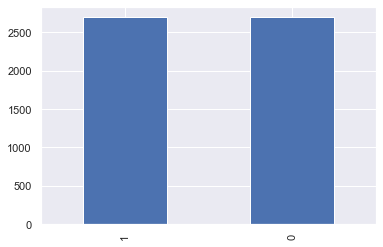

In [49]:
pd.Series(y_train_new).value_counts().plot.bar()

In [50]:
log_reg_params = {"penalty": ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],'tol':[0.001, 0.01, 0.1, 1, 10, 100, 1000], 'max_iter':[5000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train_new, y_train_new)
# We automatically get the logistic regression with the best parameters.
best_est = grid_log_reg.best_estimator_

In [51]:
best_est

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.001, verbose=0,
                   warm_start=False)

In [52]:
log_reg_pred =best_est.predict(X_test)
print('\n')
print('Classification Report: \n ' ,(classification_report(y_test,log_reg_pred)))



Classification Report: 
                precision    recall  f1-score   support

           0       0.70      0.65      0.67       169
           1       0.64      0.69      0.67       153

    accuracy                           0.67       322
   macro avg       0.67      0.67      0.67       322
weighted avg       0.67      0.67      0.67       322



In [53]:
print(pd.crosstab(y_test.ravel(),log_reg_pred.ravel(),rownames=['True'],colnames=['Predicted'],margins=True))

Predicted    0    1  All
True                    
0          110   59  169
1           47  106  153
All        157  165  322


In oversampling, the accuracy is down to 60-70%, however, only around 35-40% of the total positive cases have been misclassified.

In [54]:
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)



# Logistic Regression with SMOTE Technique
y_pred_sm = best_est.predict(X_test)
oversample_score = accuracy_score(y_test, y_pred_sm)


d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)


In [55]:
final_df

,Technique,Score
0,Random UnderSampling,0.670807
1,Oversampling (SMOTE),0.670807


Using ANN or Artificial Neural Networks

In [56]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout

For Undersample

In [57]:
X_train.shape

(966, 15)

In [58]:
from tensorflow.keras.callbacks import EarlyStopping

In [59]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [60]:
model = Sequential()

model.add(Dense(units=15,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units= 8 ,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy','Precision','Recall'])

In [61]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=600,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Train on 966 samples, validate on 322 samples
Epoch 1/600
966/966 [==============================] - 2s 2ms/sample - loss: 1.0255 - accuracy: 0.5052 - Precision: 0.5094 - Recall: 0.7169 - val_loss: 0.7868 - val_accuracy: 0.4565 - val_Precision: 0.4560 - val_Recall: 0.7451
Epoch 2/600
966/966 [==============================] - 0s 147us/sample - loss: 0.9354 - accuracy: 0.4876 - Precision: 0.4970 - Recall: 0.6762 - val_loss: 0.7395 - val_accuracy: 0.4814 - val_Precision: 0.4679 - val_Recall: 0.6667
Epoch 3/600
966/966 [==============================] - 0s 153us/sample - loss: 0.8860 - accuracy: 0.5041 - Precision: 0.5099 - Recall: 0.6293 - val_loss: 0.7081 - val_accuracy: 0.5124 - val_Precision: 0.4899 - val_Recall: 0.6340
Epoch 4/600
966/966 [==============================] - 0s 159us/sample - loss: 0.8209 - accuracy: 0.5041 - Precision: 0.5105 - Recall: 0.5967 - val_loss: 0.6912 - val_accuracy: 0.5497 - val_Precision: 0.5247 - val_Recall: 0.5556
Epoch 5/600
966/966 [===================

966/966 [==============================] - 0s 160us/sample - loss: 0.6555 - accuracy: 0.5983 - Precision: 0.6419 - Recall: 0.4745 - val_loss: 0.6517 - val_accuracy: 0.6335 - val_Precision: 0.6923 - val_Recall: 0.4118
Epoch 37/600
966/966 [==============================] - 0s 154us/sample - loss: 0.6623 - accuracy: 0.6066 - Precision: 0.6537 - Recall: 0.4807 - val_loss: 0.6496 - val_accuracy: 0.6335 - val_Precision: 0.6882 - val_Recall: 0.4183
Epoch 38/600
966/966 [==============================] - 0s 190us/sample - loss: 0.6517 - accuracy: 0.6190 - Precision: 0.6676 - Recall: 0.4990 - val_loss: 0.6486 - val_accuracy: 0.6335 - val_Precision: 0.6842 - val_Recall: 0.4248
Epoch 39/600
966/966 [==============================] - 0s 148us/sample - loss: 0.6488 - accuracy: 0.5952 - Precision: 0.6397 - Recall: 0.4664 - val_loss: 0.6466 - val_accuracy: 0.6491 - val_Precision: 0.7000 - val_Recall: 0.4575
Epoch 40/600
966/966 [==============================] - 0s 156us/sample - loss: 0.6498 - accu

966/966 [==============================] - 0s 147us/sample - loss: 0.6444 - accuracy: 0.6263 - Precision: 0.6816 - Recall: 0.4969 - val_loss: 0.6278 - val_accuracy: 0.6646 - val_Precision: 0.6860 - val_Recall: 0.5425
Epoch 72/600
966/966 [==============================] - 0s 144us/sample - loss: 0.6394 - accuracy: 0.6190 - Precision: 0.6762 - Recall: 0.4807 - val_loss: 0.6262 - val_accuracy: 0.6739 - val_Precision: 0.6935 - val_Recall: 0.5621
Epoch 73/600
966/966 [==============================] - 0s 143us/sample - loss: 0.6243 - accuracy: 0.6418 - Precision: 0.6923 - Recall: 0.5316 - val_loss: 0.6270 - val_accuracy: 0.6739 - val_Precision: 0.6935 - val_Recall: 0.5621
Epoch 74/600
966/966 [==============================] - 0s 154us/sample - loss: 0.6396 - accuracy: 0.6284 - Precision: 0.6854 - Recall: 0.4969 - val_loss: 0.6262 - val_accuracy: 0.6770 - val_Precision: 0.6960 - val_Recall: 0.5686
Epoch 75/600
966/966 [==============================] - 0s 141us/sample - loss: 0.6456 - accu

Epoch 107/600
966/966 [==============================] - 0s 152us/sample - loss: 0.6405 - accuracy: 0.6522 - Precision: 0.7123 - Recall: 0.5295 - val_loss: 0.6184 - val_accuracy: 0.6863 - val_Precision: 0.7000 - val_Recall: 0.5948
Epoch 108/600
966/966 [==============================] - 0s 141us/sample - loss: 0.6314 - accuracy: 0.6542 - Precision: 0.7127 - Recall: 0.5356 - val_loss: 0.6186 - val_accuracy: 0.6801 - val_Precision: 0.6923 - val_Recall: 0.5882
Epoch 109/600
966/966 [==============================] - 0s 142us/sample - loss: 0.6402 - accuracy: 0.6253 - Precision: 0.6777 - Recall: 0.5010 - val_loss: 0.6180 - val_accuracy: 0.6832 - val_Precision: 0.6977 - val_Recall: 0.5882
Epoch 110/600
966/966 [==============================] - 0s 152us/sample - loss: 0.6406 - accuracy: 0.6263 - Precision: 0.6776 - Recall: 0.5051 - val_loss: 0.6195 - val_accuracy: 0.6770 - val_Precision: 0.6929 - val_Recall: 0.5752
Epoch 111/600
966/966 [==============================] - 0s 150us/sample - l

966/966 [==============================] - 0s 149us/sample - loss: 0.6278 - accuracy: 0.6625 - Precision: 0.7248 - Recall: 0.5418 - val_loss: 0.6135 - val_accuracy: 0.6894 - val_Precision: 0.6934 - val_Recall: 0.6209
Epoch 143/600
966/966 [==============================] - 0s 147us/sample - loss: 0.6113 - accuracy: 0.6677 - Precision: 0.7249 - Recall: 0.5580 - val_loss: 0.6119 - val_accuracy: 0.6832 - val_Precision: 0.6835 - val_Recall: 0.6209
Epoch 144/600
966/966 [==============================] - 0s 143us/sample - loss: 0.6103 - accuracy: 0.6957 - Precision: 0.7506 - Recall: 0.6008 - val_loss: 0.6104 - val_accuracy: 0.6863 - val_Precision: 0.6857 - val_Recall: 0.6275
Epoch 145/600
966/966 [==============================] - 0s 153us/sample - loss: 0.6230 - accuracy: 0.6418 - Precision: 0.7019 - Recall: 0.5132 - val_loss: 0.6110 - val_accuracy: 0.6863 - val_Precision: 0.6857 - val_Recall: 0.6275
Epoch 146/600
966/966 [==============================] - 0s 151us/sample - loss: 0.6355 - 

966/966 [==============================] - 0s 155us/sample - loss: 0.6170 - accuracy: 0.6542 - Precision: 0.7105 - Recall: 0.5397 - val_loss: 0.6103 - val_accuracy: 0.6832 - val_Precision: 0.6735 - val_Recall: 0.6471
Epoch 178/600
966/966 [==============================] - 0s 148us/sample - loss: 0.6218 - accuracy: 0.6532 - Precision: 0.7063 - Recall: 0.5438 - val_loss: 0.6106 - val_accuracy: 0.6863 - val_Precision: 0.6757 - val_Recall: 0.6536
Epoch 179/600
966/966 [==============================] - 0s 155us/sample - loss: 0.6199 - accuracy: 0.6615 - Precision: 0.7330 - Recall: 0.5255 - val_loss: 0.6116 - val_accuracy: 0.6957 - val_Precision: 0.6846 - val_Recall: 0.6667
Epoch 00179: early stopping


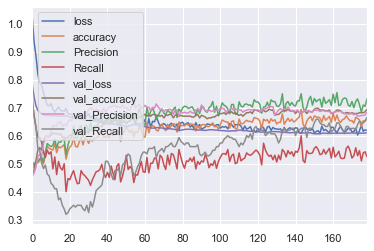

In [62]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [63]:
predictions = model.predict_classes(X_test)

In [64]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.71      0.72      0.71       169
           1       0.68      0.67      0.68       153

    accuracy                           0.70       322
   macro avg       0.69      0.69      0.69       322
weighted avg       0.70      0.70      0.70       322



In [65]:
print(pd.crosstab(y_test.ravel(),predictions.ravel(),rownames=['Actual'],colnames=['Predicted'],margins=True))

Predicted    0    1  All
Actual                  
0          122   47  169
1           51  102  153
All        173  149  322


Here, the accuracy achieved is about 60-65%, but the number of falsely classified positive cases has come down to 25-30%


For Oversample

In [66]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

In [67]:
X_train_new.shape

(5398, 15)

In [68]:
model = Sequential()
model.add(Dense(units=15,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=8,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=4,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=2,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['Precision','Recall','Accuracy'])

In [69]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [70]:
model.fit(x=X_train_new, 
          y=y_train_new, 
          epochs=600,
          validation_data=(X_test_new, y_test_new), verbose=1,
          callbacks=[early_stop]
          )

Train on 5398 samples, validate on 1060 samples
Epoch 1/600
5398/5398 [==============================] - 3s 537us/sample - loss: 0.6941 - Precision: 0.4995 - Recall: 0.5561 - Accuracy: 0.0000e+00 - val_loss: 0.6930 - val_Precision: 0.2019 - val_Recall: 0.5212 - val_Accuracy: 0.0000e+00
Epoch 2/600
5398/5398 [==============================] - 1s 133us/sample - loss: 0.6926 - Precision: 0.5248 - Recall: 0.1649 - Accuracy: 0.0000e+00 - val_loss: 0.6924 - val_Precision: 0.2147 - val_Recall: 0.4788 - val_Accuracy: 0.0000e+00
Epoch 3/600
5398/5398 [==============================] - 1s 131us/sample - loss: 0.6926 - Precision: 0.5395 - Recall: 0.1719 - Accuracy: 0.0000e+00 - val_loss: 0.6933 - val_Precision: 0.2009 - val_Recall: 0.5636 - val_Accuracy: 0.0000e+00
Epoch 4/600
5398/5398 [==============================] - 1s 133us/sample - loss: 0.6913 - Precision: 0.5569 - Recall: 0.1867 - Accuracy: 0.0000e+00 - val_loss: 0.6926 - val_Precision: 0.2065 - val_Recall: 0.5394 - val_Accuracy: 0.0000e

Epoch 35/600
5398/5398 [==============================] - 1s 137us/sample - loss: 0.6692 - Precision: 0.5474 - Recall: 0.7999 - Accuracy: 0.0000e+00 - val_loss: 0.6944 - val_Precision: 0.2049 - val_Recall: 0.7636 - val_Accuracy: 0.0000e+00
Epoch 36/600
5398/5398 [==============================] - 1s 130us/sample - loss: 0.6678 - Precision: 0.5528 - Recall: 0.8114 - Accuracy: 0.0000e+00 - val_loss: 0.6822 - val_Precision: 0.2054 - val_Recall: 0.7394 - val_Accuracy: 0.0000e+00
Epoch 37/600
5398/5398 [==============================] - 1s 130us/sample - loss: 0.6638 - Precision: 0.5585 - Recall: 0.8147 - Accuracy: 0.0000e+00 - val_loss: 0.6738 - val_Precision: 0.2112 - val_Recall: 0.7758 - val_Accuracy: 0.0000e+00
Epoch 38/600
5398/5398 [==============================] - 1s 129us/sample - loss: 0.6684 - Precision: 0.5484 - Recall: 0.8081 - Accuracy: 0.0000e+00 - val_loss: 0.6865 - val_Precision: 0.2062 - val_Recall: 0.7697 - val_Accuracy: 0.0000e+00
Epoch 39/600
5398/5398 [================

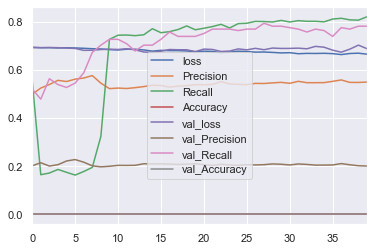

In [71]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [72]:
pred_over = model.predict_classes(X_test_new)

In [73]:
print(classification_report(y_test_new,pred_over))

              precision    recall  f1-score   support

           0       0.91      0.43      0.58       895
           1       0.20      0.78      0.32       165

    accuracy                           0.48      1060
   macro avg       0.56      0.60      0.45      1060
weighted avg       0.80      0.48      0.54      1060



In [74]:
print(pd.crosstab(y_test_new.ravel(),pred_over.ravel(),rownames=['Actual'],colnames=['Predicted'],margins=True))

Predicted    0    1   All
Actual                   
0          382  513   895
1           36  129   165
All        418  642  1060


Here, the accuracy achieved is about 50-55%, but the number of falsy classified positive cases is around 40-50%.


Random Forest Classifier

On Under Sampled

In [75]:
from sklearn.ensemble import RandomForestClassifier

In [76]:
rtc = RandomForestClassifier(n_estimators=300,max_depth = 20,random_state=42)

In [77]:
rtc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [78]:
prediction_under = rtc.predict(X_test)

In [79]:
print(classification_report(y_test,prediction_under))

              precision    recall  f1-score   support

           0       0.69      0.64      0.66       169
           1       0.63      0.67      0.65       153

    accuracy                           0.66       322
   macro avg       0.66      0.66      0.66       322
weighted avg       0.66      0.66      0.66       322



In [80]:
print(pd.crosstab(y_test.ravel(),prediction_under.ravel(),rownames=['Actual'],colnames=['Predicted'],margins=True))

Predicted    0    1  All
Actual                  
0          109   60  169
1           50  103  153
All        159  163  322


On Over Sampled

In [81]:
rtc_params = {
              'n_estimators':[300,400,500,600],
              'max_depth' : range(1,30),
              'random_state' : [42],
              'max_features' : ['auto','sqrt','log2']}
             



grid_rtc = GridSearchCV(RandomForestClassifier(), rtc_params)
grid_rtc.fit(X_train, y_train)
# We automatically get the Random Forest Classifier with the best parameters.
rtc = grid_rtc.best_estimator_

In [82]:
rtc.fit(X_train_new,y_train_new)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [83]:
prediction_over = rtc.predict(X_test_new)

In [84]:
print(classification_report(y_test_new,prediction_over))

              precision    recall  f1-score   support

           0       0.93      0.20      0.33       895
           1       0.17      0.92      0.29       165

    accuracy                           0.31      1060
   macro avg       0.55      0.56      0.31      1060
weighted avg       0.81      0.31      0.32      1060



In [85]:
print(pd.crosstab(y_test_new.ravel(),prediction_over.ravel(),rownames=['Actual'],colnames=['Predicted'],margins=True))

Predicted    0    1   All
Actual                   
0          180  715   895
1           14  151   165
All        194  866  1060
